In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import lightgbm
#from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')

In [102]:
DATA_DIR = 'data'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

#only run this cell once, at the start
#import requests, os

train_zip = "train.zip"
test_zip = "test.zip"
sample_sub = "SampleSubmission.csv"

In [103]:
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', low_memory=False)

client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv', low_memory=False)
invoice_test = pd.read_csv(f'{TEST_DIR}/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv', low_memory=False)

In [104]:
client_train['target'] = client_train['target'].astype(int)

In [105]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [106]:
# 'counter_statue'
invoice_train['counter_statue'] = invoice_train['counter_statue'].astype(str)
filtered_values = ['0', '1', '2', '3', '4', '5']
invoice_train = invoice_train[invoice_train['counter_statue'].isin(filtered_values)]

In [107]:
all_train = pd.merge(client_train, invoice_train, on='client_id', how='inner')

In [108]:
#all_train['index_diff'] = all_train['new_index'] - all_train['old_index']
all_train.eval('index_diff = new_index - old_index', inplace=True)
all_train.eval('index_diff_consom = consommation_level_1 + consommation_level_2 + consommation_level_3 + consommation_level_4', inplace=True)
all_train['index_not_consom'] = np.where(all_train['index_diff'] == all_train['index_diff_consom'], 0, 1) 
all_train['index_diff_0'] = np.where(all_train['index_diff'] == 0, 1, 0) 
all_train['index_diff_m']  = all_train['index_diff'] / all_train['months_number']

#calc monthly consumption

for var in ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']:
    all_train[var] = all_train[var] / all_train['months_number']

In [109]:
# offset comparison for Counter_number
all_train = all_train.sort_values(['client_id', 'counter_type', 'counter_number','invoice_date'])
all_train['counter_changes'] = np.where(
    (all_train['client_id'] == all_train['client_id'].shift(1)) & 
    (all_train['counter_type'] == all_train['counter_type'].shift(1)) & 
    (all_train['counter_number'] != all_train['counter_number'].shift(1)), 1, 
    0) 

In [110]:
df_train = pd.read_csv('data/df2.csv', low_memory=False)
df_train_2 = pd.read_csv('data/df_m2.csv', low_memory=False)
df_train_2['target'] = df_train_2['target'].astype(int)

In [111]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   client_id                   135493 non-null  object 
 1   target                      135493 non-null  float64
 2   transactions_count          135355 non-null  float64
 3   consommation_sum_max        135355 non-null  float64
 4   consommation_sum_min        135355 non-null  float64
 5   consommation_sum_mean       135355 non-null  float64
 6   consommation_ave_max        135355 non-null  float64
 7   consommation_ave_min        135355 non-null  float64
 8   consommation_ave_mean       135354 non-null  float64
 9   months_number_max           135355 non-null  float64
 10  months_number_min           135355 non-null  float64
 11  months_number_mean          135355 non-null  float64
 12  consumption_sum             135355 non-null  float64
 13  consumption_ma

In [112]:
df_train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 62 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   client_id                   135493 non-null  object 
 1   target                      135493 non-null  int64  
 2   transactions_count          135493 non-null  int64  
 3   consommation_level_1_mean   135493 non-null  float64
 4   consommation_level_1_max    135493 non-null  int64  
 5   consommation_level_1_min    135493 non-null  int64  
 6   consommation_level_2_mean   135493 non-null  float64
 7   consommation_level_2_max    135493 non-null  int64  
 8   consommation_level_2_min    135493 non-null  int64  
 9   consommation_level_3_mean   135493 non-null  float64
 10  consommation_level_3_max    135493 non-null  int64  
 11  consommation_level_3_min    135493 non-null  int64  
 12  consommation_level_4_mean   135493 non-null  float64
 13  consommation_l

In [113]:
df_train_2.isnull().sum().head(50)

client_id                     0
target                        0
transactions_count            0
consommation_level_1_mean     0
consommation_level_1_max      0
consommation_level_1_min      0
consommation_level_2_mean     0
consommation_level_2_max      0
consommation_level_2_min      0
consommation_level_3_mean     0
consommation_level_3_max      0
consommation_level_3_min      0
consommation_level_4_mean     0
consommation_level_4_max      0
consommation_level_4_min      0
consumption_max               0
consumption_min               0
consumption_mean              0
consumption_per_month_max     0
consumption_per_month_min     0
consumption_per_month_mean    1
months_number_max             0
months_number_min             0
months_number_mean            0
index_diff_sum                0
index_diff_max                0
index_diff_min                0
index_diff_mean               0
index_diff_per_month_max      0
index_diff_per_month_min      0
index_diff_per_month_mean     0
counter_

In [114]:
df_train_target = df_train_2.query('target==1')
df_train_notarget = df_train_2.query('target==0')

In [115]:
client_train_target = client_train.query('target==1')
client_train_notarget = client_train.query('target==0')

In [116]:
client_train.query('target == 1')

,disrict,client_id,client_catg,region,creation_date,target
41,63,train_Client_100032,11,308,07/11/2012,1
46,62,train_Client_100037,11,307,16/09/2009,1
97,69,train_Client_100083,11,107,26/10/1982,1
106,60,train_Client_100091,11,101,22/02/2011,1
126,63,train_Client_100109,11,312,27/12/1990,1
...,...,...,...,...,...,...
135407,69,train_Client_99921,11,103,06/05/2016,1
135435,69,train_Client_99947,12,103,17/11/2006,1
135443,62,train_Client_99954,11,310,23/06/1987,1
135472,69,train_Client_99980,11,103,03/06/2013,1


In [117]:
import seaborn as sns

In [118]:
df = client_train.groupby(['target', 'disrict']).size().reset_index(name='Customers') 
df['Customers (%)'] = df.groupby(['target'])['Customers'].transform(lambda x: x / x.sum() * 100)

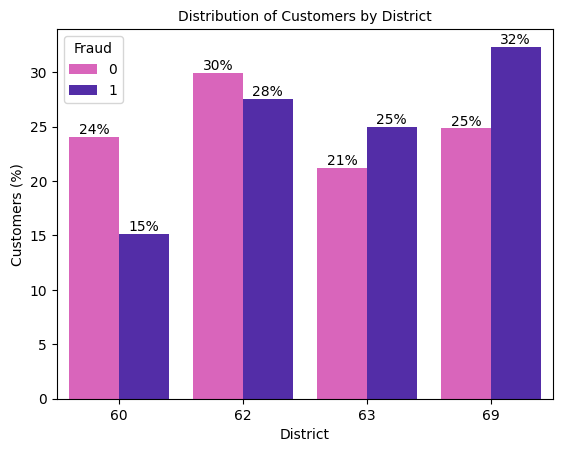

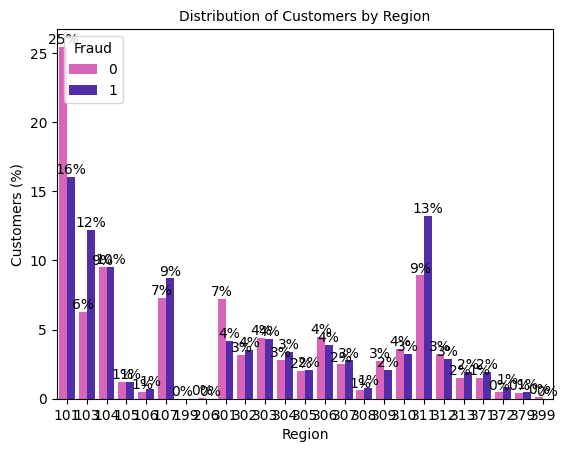

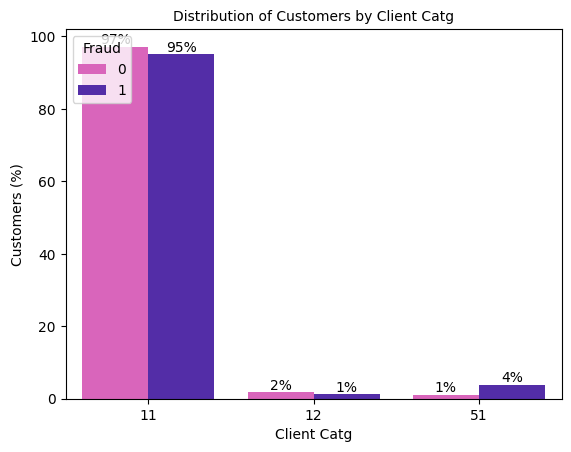

In [119]:
#Visualize client distribution across districts and regions
for col in ['disrict','region','client_catg']:
    col_cap = col.replace('disrict', 'district').title()
    col_cap = col_cap.replace('_', ' ').title()
    df = client_train.groupby(['target', col]).size().reset_index(name='Customers') 
    df['Customers (%)'] = df.groupby(['target'])['Customers'].transform(lambda x: x / x.sum() * 100)
    ax = sns.barplot(x=col, y='Customers (%)', hue='target', data=df, palette=["#EC52C4", "#4C19BB"])
    plt.xlabel(col_cap)
    titel = 'Distribution of Customers by ' + col_cap 
    plt.title(titel, fontsize = 10)

    ax.legend(title="Fraud", loc = 'upper left')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f%%')
    plt.show()

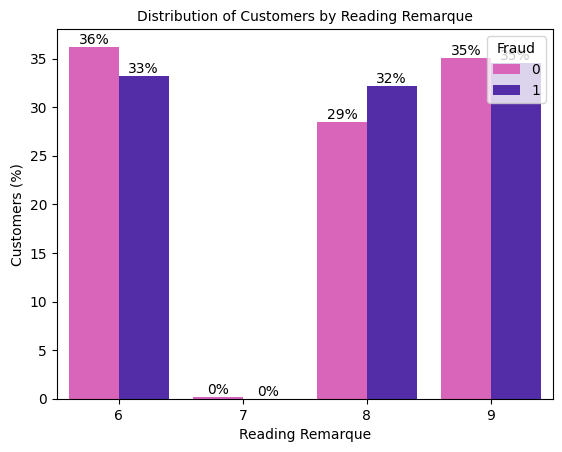

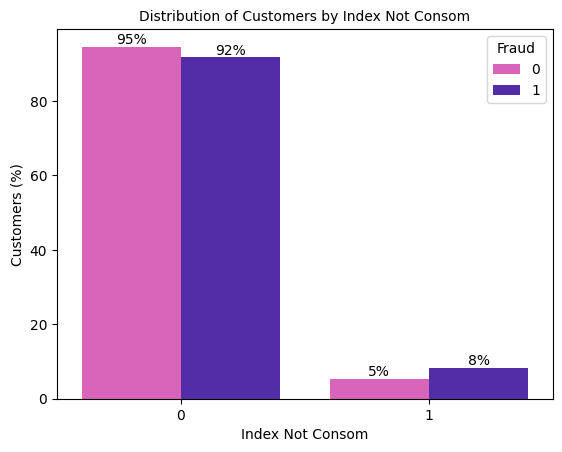

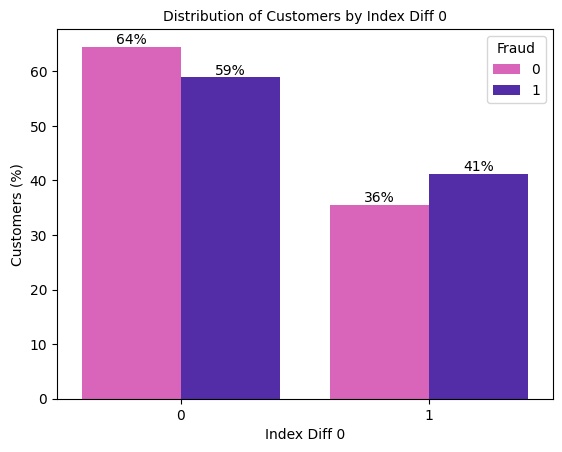

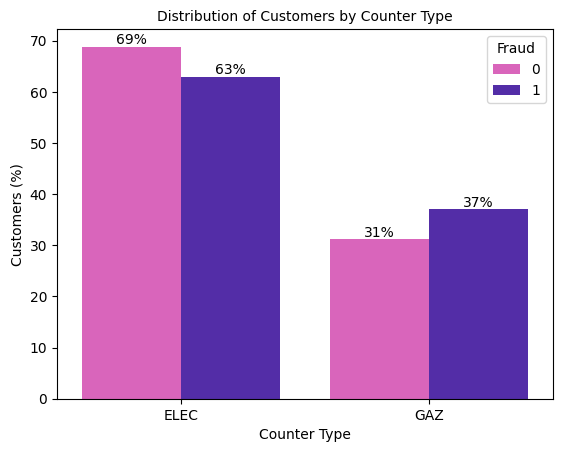

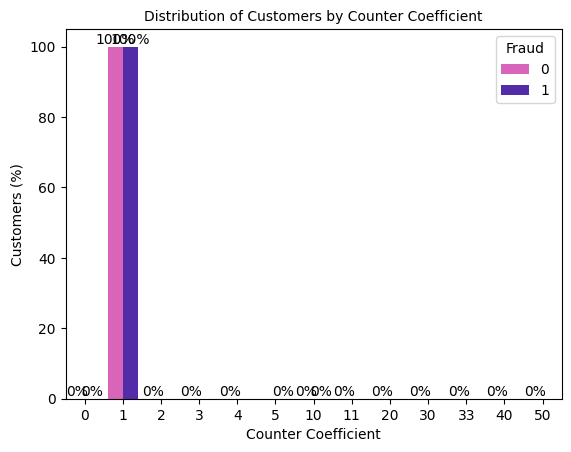

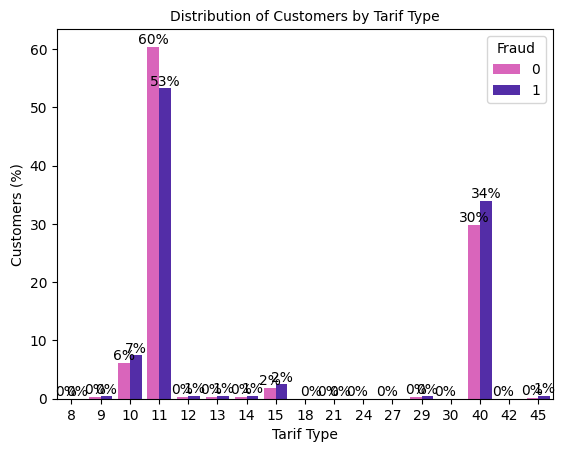

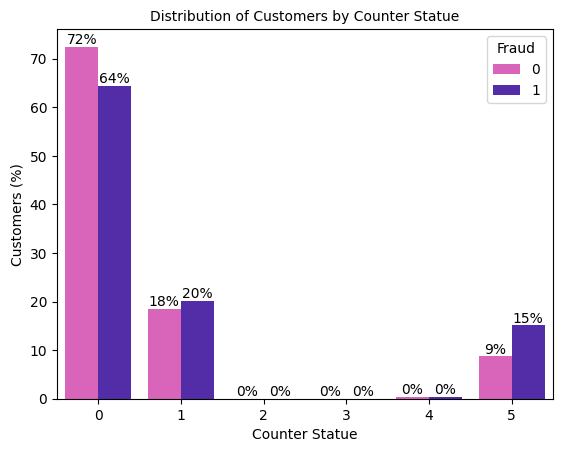

In [120]:
#Visualize client distribution across districts and regions
for col in ['reading_remarque', 'index_not_consom', 'index_diff_0', 'counter_type', 'counter_coefficient', 'tarif_type', 'counter_statue']:
    col_cap = col.replace('_', ' ').title()
    df = all_train[['client_id', 'target', col]].drop_duplicates()
    df = df.groupby(['target', col]).size().reset_index(name='Customers') 
    df['Customers (%)'] = df.groupby(['target'])['Customers'].transform(lambda x: x / x.sum() * 100)
    ax = sns.barplot(x=col, y='Customers (%)', hue='target', data=df, palette=["#EC52C4", "#4C19BB"])
    plt.xlabel(col_cap)
    titel = 'Distribution of Customers by ' + col_cap 
    plt.title(titel, fontsize = 10)

    ax.legend(title="Fraud", loc = 'upper right')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f%%')
    plt.show()

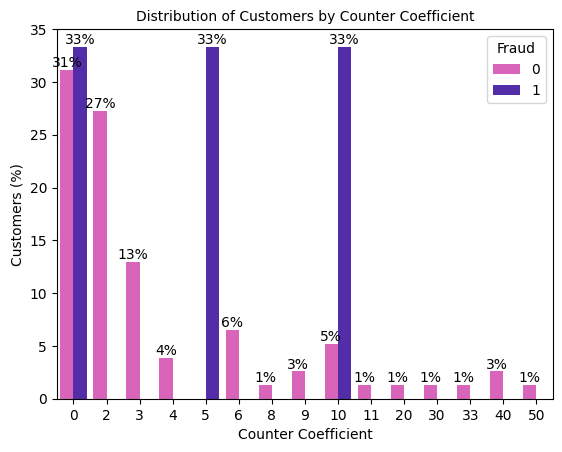

In [89]:
#Visualize client distribution across districts and regions
for col in ['counter_coefficient']:
    col_cap = col.replace('_', ' ').title()
    df = all_train[['client_id', 'target', col]].query('counter_coefficient != 1').drop_duplicates()
    df = df.groupby(['target', col]).size().reset_index(name='Customers') 
    df['Customers (%)'] = df.groupby(['target'])['Customers'].transform(lambda x: x / x.sum() * 100)
    ax = sns.barplot(x=col, y='Customers (%)', hue='target', data=df, palette=["#EC52C4", "#4C19BB"])
    plt.xlabel(col_cap)
    titel = 'Distribution of Customers by ' + col_cap 
    plt.title(titel, fontsize = 10)

    ax.legend(title="Fraud", loc = 'upper right')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f%%')
    plt.show()

In [90]:
df = all_train.groupby(['target'])['old_index'].mean().reset_index(name='Average') 
df

,target,Average
0,0,17441.927007
1,1,21563.175771


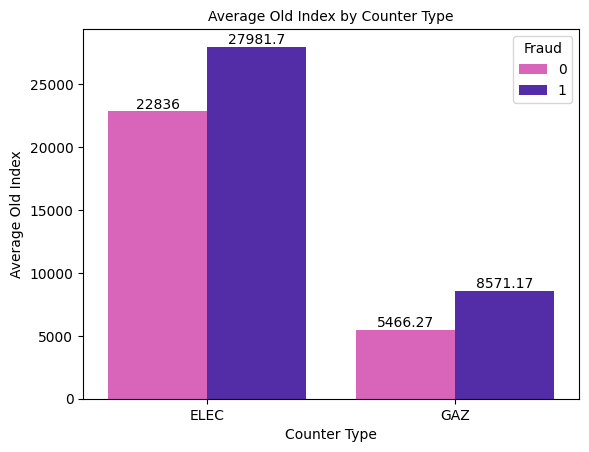

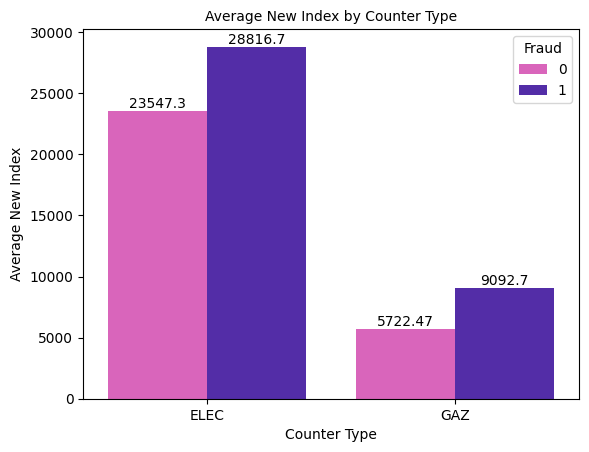

In [91]:
#Visualize client distribution across districts and regions
for col in ['old_index', 'new_index']:
    col_cap = col.replace('_', ' ').title()
    df = all_train.groupby(['target', 'counter_type'])[col].mean().reset_index(name='Average') 
    ax = sns.barplot(x='counter_type', y='Average', hue='target', data=df, palette=["#EC52C4", "#4C19BB"])
    plt.xlabel('Counter Type')
    plt.ylabel('Average ' + col_cap)
    titel = 'Average ' + col_cap  + " by Counter Type"
    plt.title(titel, fontsize = 10)

    ax.legend(title="Fraud", loc = 'upper right')

    for container in ax.containers:
        ax.bar_label(container)#, fmt='%.0f%%')
    plt.show()

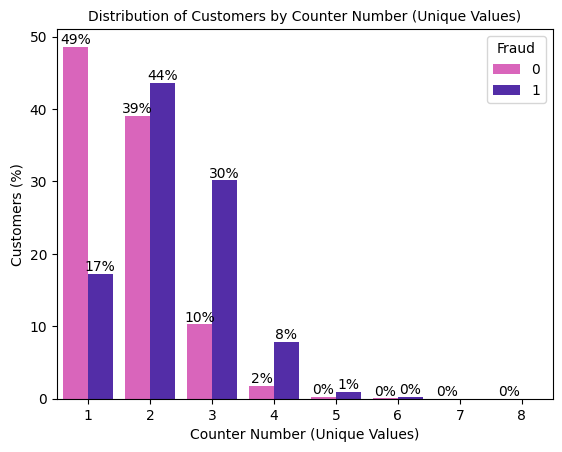

In [92]:
#Visualize client distribution across districts and regions
for col in ['counter_number_nunique']:
    col_cap = col.replace('_', ' ').title()
    col_cap = col_cap.replace('Nunique', '(Unique Values)')
    df = df_train_2[['client_id', 'target', col]]
    df = df.groupby(['target', col]).size().reset_index(name='Customers') 
    df['Customers (%)'] = df.groupby(['target'])['Customers'].transform(lambda x: x / x.sum() * 100)
    ax = sns.barplot(x=col, y='Customers (%)', hue='target', data=df, palette=["#EC52C4", "#4C19BB"])
    plt.xlabel(col_cap)
    titel = 'Distribution of Customers by ' + col_cap 
    plt.title(titel, fontsize = 10)

    ax.legend(title="Fraud", loc = 'upper right')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f%%')
    plt.show()

In [93]:
all_train

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,old_index,new_index,months_number,counter_type,index_diff,index_diff_consom,index_not_consom,index_diff_0,index_diff_m,counter_changes
22,60,train_Client_0,11,101,31/12/1994,0,2005-10-17,11,1335667,0,...,3685,3809,4,ELEC,124,124,0,0,31.000,0
23,60,train_Client_0,11,101,31/12/1994,0,2006-02-24,11,1335667,0,...,3809,3950,4,ELEC,141,141,0,0,35.250,0
24,60,train_Client_0,11,101,31/12/1994,0,2006-06-23,11,1335667,0,...,3950,4112,4,ELEC,162,162,0,0,40.500,0
25,60,train_Client_0,11,101,31/12/1994,0,2006-10-18,11,1335667,0,...,4112,4271,4,ELEC,159,159,0,0,39.750,0
28,60,train_Client_0,11,101,31/12/1994,0,2007-02-26,11,1335667,0,...,4271,4453,4,ELEC,182,182,0,0,45.500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,60,train_Client_99998,11,101,22/12/1993,0,2005-08-19,10,1253571,0,...,3197,3732,8,ELEC,535,535,0,0,66.875,0
4476745,60,train_Client_99998,11,101,22/12/1993,0,2005-12-19,10,1253571,0,...,3732,3938,4,ELEC,206,206,0,0,51.500,0
4476748,60,train_Client_99999,11,101,18/02/1986,0,1996-01-25,11,560948,0,...,12765,13281,4,ELEC,516,516,0,0,129.000,0
4476747,60,train_Client_99999,11,101,18/02/1986,0,1996-05-28,11,560948,0,...,13281,13884,4,ELEC,603,603,0,0,150.750,0


In [94]:
# Create new column for year-month
#convert the column invoice_date to date time format on both the invoice train and invoice test
all_train['invoice_date'] = pd.to_datetime(all_train['invoice_date'])
all_train['invoice_month'] = all_train['invoice_date'].dt.strftime('%Y-%m')
all_train['invoice_year'] = all_train.invoice_date.dt.year

In [95]:
all_train.query("invoice_year >= 2005").groupby(['counter_type']).count()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,new_index,months_number,index_diff,index_diff_consom,index_not_consom,index_diff_0,index_diff_m,counter_changes,invoice_month,invoice_year
counter_type,,,,,,,,,,,,,,,,,,,,,
ELEC,3059497,3059497,3059497,3059497,3059497,3059497,3059497,3059497,3059497,3059497,...,3059497,3059497,3059497,3059497,3059497,3059497,3059497,3059497,3059497,3059497
GAZ,1395140,1395140,1395140,1395140,1395140,1395140,1395140,1395140,1395140,1395140,...,1395140,1395140,1395140,1395140,1395140,1395140,1395138,1395140,1395140,1395140


In [96]:
all_train.query("invoice_year >= 2005").count()

disrict                 4454637
client_id               4454637
client_catg             4454637
region                  4454637
creation_date           4454637
target                  4454637
invoice_date            4454637
tarif_type              4454637
counter_number          4454637
counter_statue          4454637
counter_code            4454637
reading_remarque        4454637
counter_coefficient     4454637
consommation_level_1    4454637
consommation_level_2    4454635
consommation_level_3    4454635
consommation_level_4    4454635
old_index               4454637
new_index               4454637
months_number           4454637
counter_type            4454637
index_diff              4454637
index_diff_consom       4454637
index_not_consom        4454637
index_diff_0            4454637
index_diff_m            4454635
counter_changes         4454637
invoice_month           4454637
invoice_year            4454637
dtype: int64

In [97]:
# On monthly level
df_target_gaz_yearly = all_train.query("target == 1 & counter_type == 'GAZ' & invoice_year >= 2005").groupby(['invoice_year']).size().reset_index(name='Invoices') 
df_target_gaz_yearly['Average'] = df_target_gaz_yearly['Invoices'].mean()
df_target_gaz_yearly

# On monthly level
df_not_gaz_yearly = all_train.query("target == 0 & counter_type == 'GAZ' & invoice_year >= 2005").groupby(['invoice_year']).size().reset_index(name='Invoices') 
df_not_gaz_yearly['Average'] = df_not_gaz_yearly['Invoices'].mean()
df_not_gaz_yearly

# On monthly level
df_target_elec_yearly = all_train.query("target == 1 & counter_type == 'ELEC' & invoice_year >= 2005").groupby(['invoice_year']).size().reset_index(name='Invoices') 
df_target_elec_yearly['Average'] = df_target_elec_yearly['Invoices'].mean()
df_target_elec_yearly

# On monthly level
df_not_elec_yearly = all_train.query("target == 0 & counter_type == 'ELEC' & invoice_year >= 2005").groupby(['invoice_year']).size().reset_index(name='Invoices') 
df_not_elec_yearly['Average'] = df_not_elec_yearly['Invoices'].mean()
df_not_elec_yearly

,invoice_year,Invoices,Average
0,2005,48503,188209.933333
1,2006,157345,188209.933333
2,2007,171189,188209.933333
3,2008,180012,188209.933333
4,2009,188679,188209.933333
5,2010,201749,188209.933333
6,2011,193865,188209.933333
7,2012,198707,188209.933333
8,2013,205502,188209.933333
9,2014,210072,188209.933333


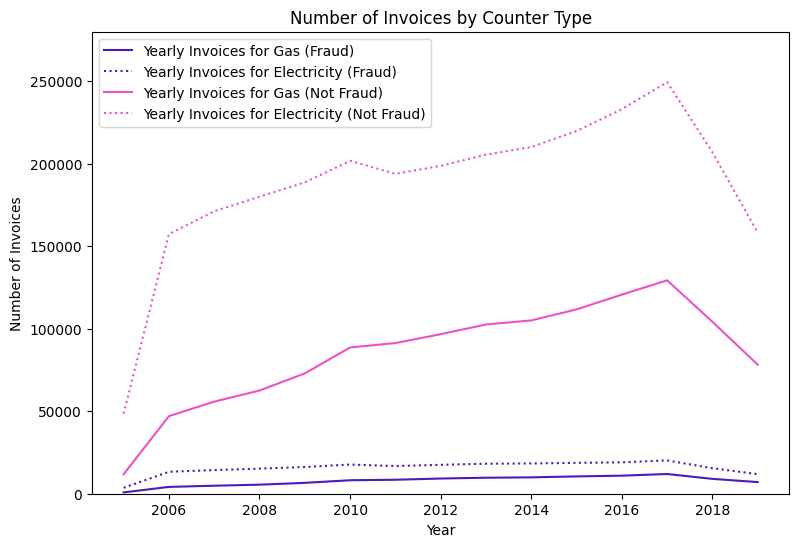

In [122]:
f, ax = plt.subplots(1, figsize=[9, 6])
plt.plot(df_target_gaz_yearly['invoice_year'], 
            df_target_gaz_yearly['Invoices'],
            label = "Yearly Invoices for Gas (Fraud)",
            color = "#4C19BB")

plt.plot(df_target_elec_yearly['invoice_year'], 
            df_target_elec_yearly['Invoices'],
            label = "Yearly Invoices for Electricity (Fraud)",
            linestyle = 'dotted',
            color = "#4C19BB")

plt.plot(df_not_gaz_yearly['invoice_year'], 
            df_not_gaz_yearly['Invoices'],
            label = "Yearly Invoices for Gas (Not Fraud)",
            color = "#EC52C4")
plt.plot(df_not_elec_yearly['invoice_year'], 
            df_not_elec_yearly['Invoices'],
            label = "Yearly Invoices for Electricity (Not Fraud)",
            linestyle = 'dotted',
            color = "#EC52C4")

plt.title('Number of Invoices by Counter Type')
plt.xlabel('Year')
plt.ylabel('Number of Invoices')
ax.set_ylim(bottom=0, top=280000)

plt.legend()
plt.show()